# 1. Exploratory data analysis (EDA)

An exploratory data analysis shows the raw data: the photoplethysmogram (PPG) and the 3D accelerometer (ACCx, ACCy and ACCz) signals, and also the reference or "ground truth" signal. 
First, the analysis in the time domain is presented, then followed by the analysis in the frequency domain. 
Conclusions from these analyses are used to build the pulse rate estimation algorithm described in Part 2.

In [1]:
# Importing packages

import glob
import numpy as np
import scipy as sp
import pandas as pd
import scipy.io
import scipy.signal
import joblib
import matplotlib.pyplot as plt

In [2]:
# Function definition

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./DataSet"    
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    
    return data[2:]


def LoadData(data_fl, ref_fl):
    """
    Extract signals from data and reference files with the correspondent subject identification for successive data processing

    Args:
        data_fl: a list of all filepaths to troika .mat files containing the signal data
        ref_fls: a list of all filepaths to .mat files containing reference data
        
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    
    Returns:
        sub_id: (np.array) The subject id that the datapoint came from
        signals: (np.array) Signal matrix
        target: (np.array) Reference signals matrix
        
    """
    data_fls, ref_fls = LoadTroikaDataset()
    sub_id, signals, target = [], [], []
    
    for i in range(len(data_fls)):
        
        _id = data_fls[i].replace('./datasets/troika/training_data/', '') 
        sub_id.append(_id.replace('.mat', ''))
        
        signals.append(LoadTroikaDataFile(data_fls[i]))
        
        target.append(sp.io.loadmat(ref_fls[10])['BPM0'][2:])
           
    return sub_id, signals, target

def BandpassFilter(signal, fs, order, passband):
    """
    Band pass filter

    Args:
        signal: Signal to be filtered
        fs: Sample frequency of the signal
        order: Order of the filter
        passband: A tuple containing the limits of the pass band as (min, max)
        
    Returns:
        sp.signal.filtfilt(b, a, signal): Filtered signal
    """
    b, a = sp.signal.butter(order, passband, btype='bandpass', fs=fs)
    
    return sp.signal.filtfilt(b, a, signal)

## 1.1 Time domain analysis
The original signals are plotted and compared with a (bandpass) filtered version in the time domain. The reference, or "ground truth", signal is also plotted.

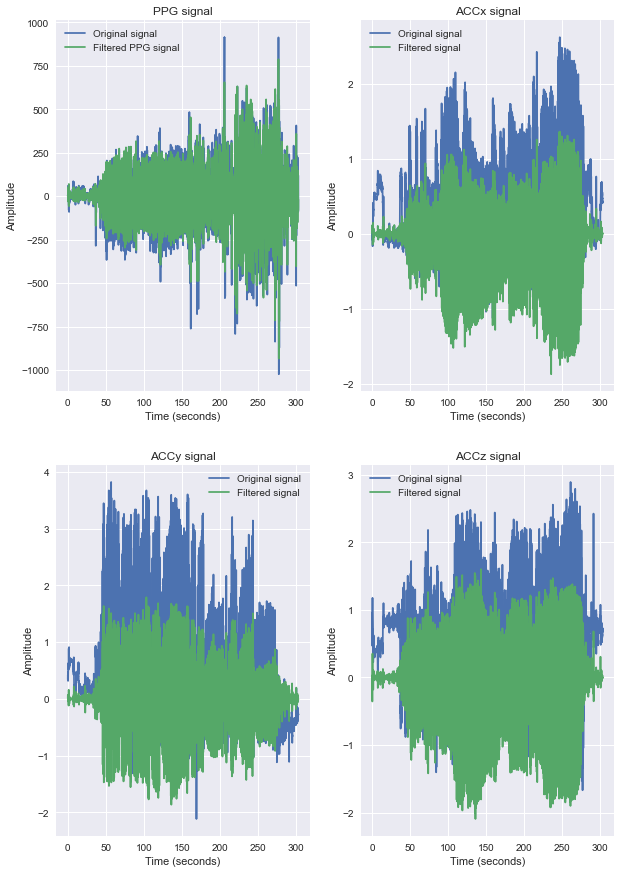

In [3]:
plt.style.use("seaborn") # Plotting style
fs = 125 # Sample frequency

data_fls, ref_fls = LoadTroikaDataset()

# Load signals
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])
ts = np.arange(0, len(ppg)/fs, 1/fs)

# Filtering signals
filt_ppg = BandpassFilter(ppg, fs, 3, (0.67, 4))
filt_accx = BandpassFilter(accx, fs, 3, (0.67, 4))
filt_accy = BandpassFilter(accy, fs, 3, (0.67, 4))
filt_accz = BandpassFilter(accz, fs, 3, (0.67, 4))

# Plotting signals
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, 
                                            ncols=2,
                                            figsize=(10,15))

ax0.plot(ts, ppg, label="Original signal")
ax0.plot(ts, filt_ppg, label="Filtered PPG signal")
ax0.set(title="PPG signal",
        xlabel="Time (seconds)",
        ylabel="Amplitude")
ax0.legend()

ax1.plot(ts, accx, label="Original signal")
ax1.plot(ts, filt_accx, label="Filtered signal")
ax1.set(title="ACCx signal",
        xlabel="Time (seconds)",
        ylabel="Amplitude");
ax1.legend()

ax2.plot(ts, accy, label="Original signal")
ax2.plot(ts, filt_accy, label="Filtered signal")
ax2.set(title="ACCy signal",
        xlabel="Time (seconds)",
        ylabel="Amplitude");
ax2.legend()

ax3.plot(ts, accz, label="Original signal")
ax3.plot(ts, filt_accz, label="Filtered signal");
ax3.set(title="ACCz signal",
        xlabel="Time (seconds)",
        ylabel="Amplitude");
ax3.legend();

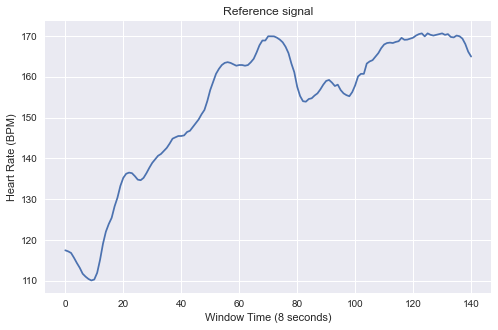

In [4]:
# Loading and plotting reference signal
ref = sp.io.loadmat(ref_fls[10])['BPM0'][2:]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(ref);

ax.set(title="Reference signal",
       xlabel="Window Time (8 seconds)",
       ylabel="Heart Rate (BPM)");

## 1.2 Frequency domain analysis

the first section shows the plots of the fast Fourier transform (FFT) and the spectogram of each original signal (PPG, ACCx, ACCy and ACCz) and the vector magnitude of the 3D force on the accelerometer, named as ACC_l2. Comparisons of these plots demonstrate the potential influence of external sources on the PPG signal, such the movement of the subject, in order to reduce the noise. 

### FFT

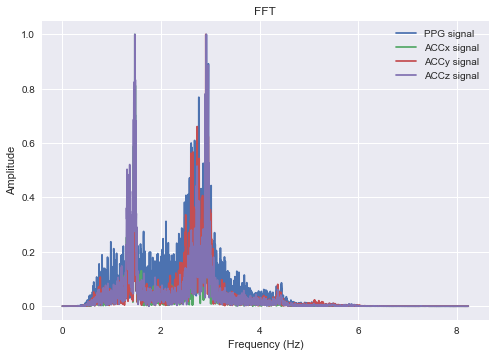

In [5]:
freqs = np.fft.rfftfreq(len(filt_ppg), 1/fs)
fft = np.fft.rfft(filt_ppg)

freqs1 = np.fft.rfftfreq(len(filt_accx), 1/fs)
fft1 = np.fft.rfft(filt_accx)

freqs2 = np.fft.rfftfreq(len(filt_accy), 1/fs)
fft2 = np.fft.rfft(filt_accy)

freqs3 = np.fft.rfftfreq(len(filt_accz), 1/fs)
fft3 = np.fft.rfft(filt_accz)

plt.plot(freqs[0:2500], np.abs(fft[0:2500])/np.max(np.abs(fft)), label="PPG signal")
plt.plot(freqs1[0:2500], np.abs(fft1[0:2500])/np.max(np.abs(fft1)), label="ACCx signal")
plt.plot(freqs2[0:2500], np.abs(fft2[0:2500])/np.max(np.abs(fft2)), label="ACCy signal")
plt.plot(freqs3[0:2500], np.abs(fft3[0:2500])/np.max(np.abs(fft3)), label="ACCz signal")

plt.title("FFT")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend();

The plot shows how PPG and ACC signals have a coincidence at the frequency maximum peak.

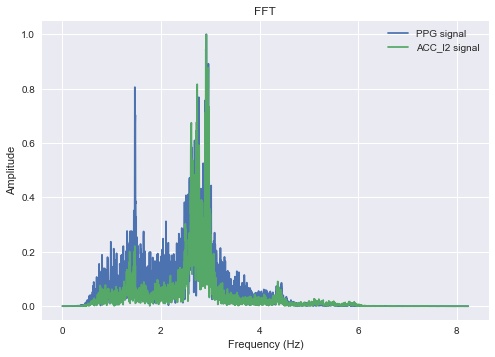

In [6]:
filt_acc = [[filt_accx],
            [filt_accy],
            [filt_accz]]

# Vector magnitude of the force on the accelerometer in 3D space
acc_l2 = np.sqrt(accx**2 + accy**2 + accz**2)
filt_acc_l2 = BandpassFilter(acc_l2, fs, 3, (0.67, 4))


freqs4 = np.fft.rfftfreq(len(filt_ppg), 1/fs)
fft4 = np.fft.rfft(filt_ppg)

freqs5 = np.fft.rfftfreq(len(filt_acc_l2), 1/fs)
fft5 = np.fft.rfft(filt_acc_l2)

plt.plot(freqs4[0:2500], np.abs(fft4[0:2500])/np.max(np.abs(fft4)), label="PPG signal")
plt.plot(freqs5[0:2500], np.abs(fft5[0:2500])/np.max(np.abs(fft5)), label="ACC_l2 signal");

plt.title("FFT")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend();

The vector magnitude of the 3D ACC signal allows a unified representation of the space and keeps showing its influence on the PPG frequency content.

### Spectrogram

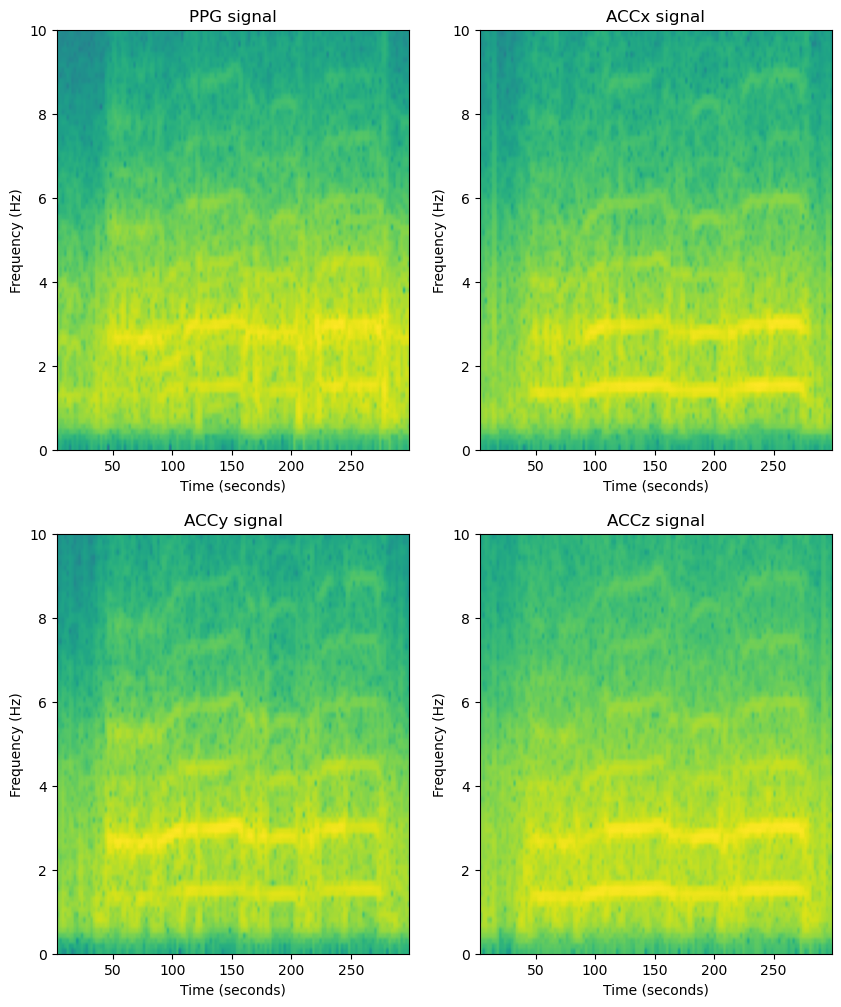

In [7]:
plt.style.use("default")

fig, ((ax4, ax5), (ax6, ax7)) = plt.subplots(nrows=2, 
                                            ncols=2,
                                            figsize=(10,12))

spec_ppg, freqs_ppg, _, _ = ax4.specgram(filt_ppg, NFFT=fs*8, Fs=fs, noverlap=fs*6)
ax4.set_ylim(0, 10)

ax4.set(title="PPG signal",
        xlabel="Time (seconds)",
        ylabel="Frequency (Hz)");

spec_accx, freqs_accx, _, _ = ax5.specgram(filt_accx, NFFT=fs*8, Fs=fs, noverlap=fs*6)
ax5.set_ylim(0, 10)

ax5.set(title="ACCx signal",
        xlabel="Time (seconds)",
        ylabel="Frequency (Hz)");

spec_accy, freqs_accy, _, _ = ax6.specgram(filt_accy, NFFT=fs*8, Fs=fs, noverlap=fs*6)
ax6.set_ylim(0, 10)

ax6.set(title="ACCy signal",
        xlabel="Time (seconds)",
        ylabel="Frequency (Hz)");

spec_accz, freqs_accz, _, _ = ax7.specgram(filt_accz, NFFT=fs*8, Fs=fs, noverlap=fs*6)
ax7.set_ylim(0, 10);

ax7.set(title="ACCz signal",
        xlabel="Time (seconds)",
        ylabel="Frequency (Hz)");

Again, the spectogram shows how PPG and ACC signals have a coincidence at the maximum frequency. 

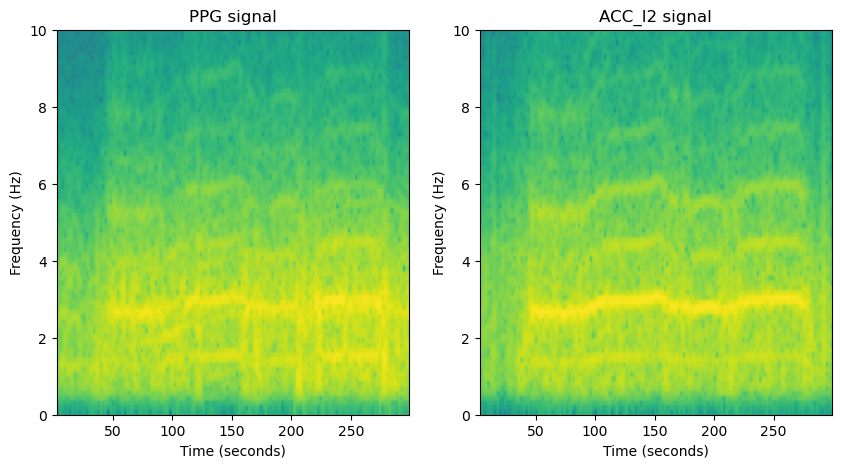

In [8]:
plt.style.use("default")

fig, (ax8, ax9) = plt.subplots(nrows=1, 
                               ncols=2,
                               figsize=(10,5))

spec_ppg, freqs_ppg, _, _ = ax8.specgram(filt_ppg, NFFT=fs*8, Fs=fs, noverlap=fs*6)
ax8.set_ylim(0, 10)

ax8.set(title="PPG signal",
        xlabel="Time (seconds)",
        ylabel="Frequency (Hz)");

spec_acc_l2, freqs_acc_l2, _, _ = ax9.specgram(filt_acc_l2, NFFT=fs*8, Fs=fs, noverlap=fs*6)
ax9.set_ylim(0, 10)

ax9.set(title="ACC_l2 signal",
        xlabel="Time (seconds)",
        ylabel="Frequency (Hz)");

Additionally, the spectogram of the vector magnitude of the 3D ACC signal allows a unified representation of the space and keeps showing its influence on the PPG frequency content.

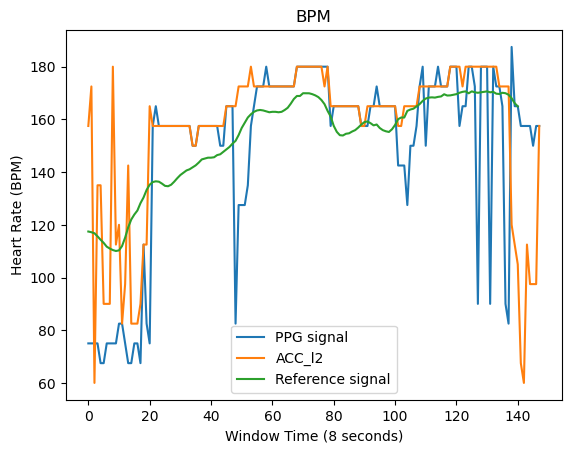

In [28]:
step_rate_ppg = freqs_ppg[np.argmax(spec_ppg, axis=0)]
step_rate_acc_l2 = freqs_acc_l2[np.argmax(spec_acc_l2, axis=0)]

plt.plot(step_rate_ppg*60, label="PPG signal")
plt.plot(step_rate_acc_l2*60, label="ACC_l2")
plt.plot(ref, label="Reference signal");

plt.title("BPM")
plt.xlabel("Window Time (8 seconds)")
plt.ylabel("Heart Rate (BPM)")
plt.legend();

### Conclusions
The 3D ACC signals demonstrate the impact of external sources to the PPG signal, as the frequency content shows. To improve the pulse rate estimation algorithm proposed in the next part, this impact is reduced using a custom made function (Featurize) to prepare the feature matrix.